# 1. Import packages

In [73]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# 2. Loading a pre-processed data set

In [2]:
path = './dataset/toyset/'
filename = 'processed_toyset.csv'
df = pd.read_csv(path + filename)

#### Define dataset row/column sizes to begin with

In [3]:
nrow = 3
ncol = 3

In [4]:
proc_covar = 0.0001**2*np.identity(nrow)
post_covar = proc_covar
meas_covar = 0.0003**2*np.identity(nrow)
pred_covar = meas_covar
ident = np.identity(nrow)

In [5]:
state_old = np.ones((3, 1))
emit_mat = np.array([[1., -1, 0.],
                      [1.,  0, -1.],
                      [0., -1., 1.],
                      ])
obs_mat = df.drop(['timestamp', 'time_gap'], axis=1)
obs_mat = obs_mat.to_numpy()
time_gap = df.time_gap.to_numpy().reshape(-1,1)

latent_states = np.empty(shape=(df.shape[0], nrow))
predicted_obs = np.empty(shape=(df.shape[0], nrow))

## Kalman updates

#### Assumptions:
- the order of measurements is GBPJPY, GBPUSD, USDJPY.
- the order of latent variables is GBP, JPY, USD.

In [6]:
ccy_list = ['gbpjpy', 'gbpusd', 'usdjpy']
latent_cols = ['GBP', 'JPY', 'USD']

In [7]:
for i in range(df.shape[0]):
    post_covar = post_covar + time_gap[i]*proc_covar

    # obs_mat[i,:] is a (3,) vector. So, we need flatten() to match
    innovation = obs_mat[i, :] - (emit_mat@state_old).flatten()
    innovation_covar = emit_mat@post_covar@(emit_mat.T) + meas_covar
    kalman_gain = post_covar@(emit_mat.T)@np.linalg.inv(innovation_covar)

    # We transpose (kalman_gain@innovation) from (3,) to (3,1)
    state_new = state_old + (kalman_gain@innovation).reshape(-1, 1)
    post_covar = (ident - kalman_gain@emit_mat)@post_covar
    predicted_obs[i] = (emit_mat@state_new).T
    latent_states[i] - state_new.T
    state_old = state_new

#### Remove the oldest timestamp and shift each row upward by one row.
- e.g. If the raw dataset starts from 2019-05-01 00:00:00 at 0th element, predictions would start from 2019-05-01 00:00:01 at 0th element instead ('lead' by one minute)

In [8]:
new_idx = df.timestamp.shift(-1).to_numpy().reshape(-1, 1)
predictions = np.hstack((new_idx, predicted_obs))
latent_estimates = np.hstack((new_idx, latent_states))

In [9]:
assert predictions.shape[0] == predicted_obs.shape[0], "We have some data loss."
assert latent_estimates.shape[0] == latent_states.shape[0], "We have some data loss."

#### Convert arrays to DataFrame instances

In [10]:
predictions = pd.DataFrame(predictions, columns=['timestamp'] + ccy_list)
latent_estimates = pd.DataFrame(latent_estimates,
                                columns=['timestampe'] + latent_cols)

## How good are the predictions?

#### It's worse than the baseline. Let's see what's going on:

As we expected, currency exchange rates are extremely volatile, and our naive approach fails. Then again, the covariance matrices are not estimated in this case, and there may be a setting that works better. But on the bright side, the graph of currency intrinsic values is really neat:

## Parameter Estimation: EM

So the goal of the project is to build an adaptive Kalman Filter. However, the problem is impossible at our current level, so we have to do a middle ground. A Kalman Smoother allows us to estimate the covariance matrices through the EM algorithm, but it requires using future data to predict the past. By combining a Kalman Smoother with PSIS detailed in the next section, we construct an algorithm to do filtering in a heuristic fashion.

### E step
- The forward pass propagates through the system, given fixed covariance matrices.
- It outputs both the predicted states and the predicted measurements.

In [28]:
ident

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [66]:
def forward_pass(data, initial_state, emit_mat, meas_covar, proc_covar, post_covar):
    '''
    Parameters:
      data(DataFrame, ): a (batch) dataset
    '''
    obs_mat = data.drop(['timestamp', 'time_gap'], axis=1)
    obs_mat = obs_mat.to_numpy()
    time_gap = data.time_gap.to_numpy().reshape(-1,1)

    latent_states = np.empty((data.shape[0], nrow))
    predicted_obs = np.empty((data.shape[0], nrow))

    state_old = initial_state    

    for i in range(data.shape[0]):
        post_covar = post_covar + time_gap[i]*proc_covar

        # obs_mat[i,:] is a (3,) vector. So, we need flatten() to match
        innovation = obs_mat[i, :] - (emit_mat@state_old).flatten()
        innovation_covar = emit_mat@post_covar@(emit_mat.T) + meas_covar
        kalman_gain = post_covar@(emit_mat.T)@np.linalg.inv(innovation_covar)

        # We transpose (kalman_gain@innovation) from (3,) to (3,1)
        state_new = state_old.reshape(-1, 1) + (kalman_gain@innovation).reshape(-1, 1)
        post_covar = (ident - kalman_gain@emit_mat)@post_covar
        predicted_obs[i] = (emit_mat@state_new).T
        latent_states[i] = state_new.T
        state_old = state_new
        
    new_idx = data.timestamp.shift(-1).to_numpy().reshape(-1, 1)
    predicted_obs = np.array(predicted_obs)
    latent_states = np.array(latent_states)
    predictions = np.hstack((new_idx, predicted_obs))
    predictions = np.hstack((predictions, time_gap))
    latent_estimates = np.hstack((new_idx, latent_states))
    latent_estimates = np.hstack((latent_estimates, time_gap))
    
    return predictions, latent_estimates, post_covar, innovation_covar
    

### M step

In [62]:
def update_proc_scale(latent_estimates):
    '''
    Takes the scale matrix of the propagated states.
    But we have to take into account the uneven time gaps.
    '''
    # drop any row with na
    latent_estimates = latent_estimates.dropna(how='any')
    time_gap = latent_estimates.time_gap
    
    # drop two columns
    latent_estimates = latent_estimates.drop(['timestamp', 'time_gap'], axis=1)

    sample_means = [np.average(latent_estimates[ccy], weights=time_gap) for ccy in latent_cols]
    latent_estimates = latent_estimates[latent_cols] - sample_means
    
    return (latent_estimates.T)@latent_estimates

def update_meas_scale(pred, obs):
    '''
    Gets us the observed scale matrix through (biased) MLE.
    The debiasing is done by supplying the correct df to the invWishart
    '''
    unique_timestamp = np.sort(np.unique(np.union1d(pred['timestamp'].dropna(
        how='any').to_numpy(), obs['timestamp'].dropna(how='any').to_numpy())))

    obs_mat = obs[np.isin(obs.timestamp, unique_timestamp)]
    pred_mat = pred[np.isin(pred.timestamp, unique_timestamp)]

    obs_pred_mat = pd.merge(left=obs_mat, right=pred_mat,
                            how='inner', on='timestamp', suffixes=('_obs', '_pred'))

    ccy_list_obs = [ccy+'_obs' for ccy in ccy_list]
    ccy_list_pred = [ccy+'_pred' for ccy in ccy_list]

    error_mat = np.array(obs_pred_mat[ccy_list_pred], dtype=float) - np.array(obs_pred_mat[ccy_list_obs], dtype=float) 
    return (error_mat.T)@error_mat

In [63]:
# check.append(update_proc_covar(check[1]))
# check.append(update_meas_scale(pred=check[0], obs=training[:100]))

### EM

In [67]:
def kalman_smoother(data, prior_state, meas_mat, post_covar, prior_meas_df, prior_meas_scale, prior_proc_df, prior_proc_scale):
    '''
    Runs the smoother on a time block through EM
    '''
    nrow = data.shape[0]
    predicted_measurements, states, post_covar, innovation_covar = \
        forward_pass(data=data, initial_state=prior_state,
                     emit_mat=meas_mat, meas_cover=prior_meas_scale/prior_meas_df,
                     proc_covar=prior_proc_scale/prior_proc_df,
                     post_covar=post_covar)

    post_proc_scale = update_proc_scale(states)
    post_meas_scale = update_meas_scale(pred=predicted_measurements, obs=data)

    old_proc_scale = post_proc_scale*2
    old_meas_scale = post_meas_scale*2

    while np.sqrt(np.sum(((old_proc_scale - post_proc_scale)/nrow)**2) +
                  np.sum(((meas_covar_old-meas_covar_new)/nrow)**2)) > 10**(-12):
        print(np.sum(((old_proc_scale - post_proc_scale)/nrow)**2 +
                     np.sum(((meas_covar_old-meas_covar_new)/nrow)**2)))

        old_meas_scale = post_meas_scale
        old_proc_scale = post_proc_scale

        predicted_measurements, states, post_covar, innovation_covar = \
            forward_pass(data=data, initial_state=prior_state,
                         emit_mat=meas_mat, meas_cover=post_meas_scale/nrow,
                         proc_covar=post_proc_scale/nrow,
                         post_covar=post_covar)

        post_proc_scale = update_proc_scale(states)
        post_meas_scale = update_meas_scale(pred=predicted_measurements, obs=data)

    post_proc_sf = prior_proc_df + nrow - emit_mat.shape[1]
    post_meas_df = prior_meas_df + nrow - emit_mat.shape[0]

    return data, states, predicted_measurements, post_meas_df, \
        prior_meas_scale + post_meas_scale, post_proc_df, \
        prior_proc_scale + post_proc_scale, post_covar, innovation_covar

In [68]:
training = df.loc[:100, :]

predictions, _, _, _ = forward_pass(data=training[:100],
                                    initial_state=np.array([2.7, -2.2, 2.5]),
                                    emit_mat=emit_mat,
                                    meas_covar=0.01*np.identity(nrow),
                                    proc_covar=0.001*np.identity(nrow),
                                    post_covar=0.001*np.identity(nrow))

# Convert to pandas Data Frame
predictions = pd.DataFrame(predictions,
                           columns=['timestamp'] + ccy_list + ['time_gap'])


# check = []
# check.append(predictions)
# check.append(latent_estimates)


predicted_obs (100, 3)
latent_states (100, 3)
new_idx (100, 1)
time_gap (100, 1)


In [69]:
predictions

,timestamp,gbpjpy,gbpusd,usdjpy,time_gap
0,2019-05-01 00:01:00,4.92991,0.224655,4.70526,1
1,2019-05-01 00:02:00,4.95001,0.241215,4.70879,1
2,2019-05-01 00:03:00,4.96229,0.251342,4.71095,1
3,2019-05-01 00:04:00,4.96957,0.257337,4.71223,1
4,2019-05-01 00:05:00,4.97383,0.260847,4.71298,1
...,...,...,...,...,...
95,2019-05-01 01:36:00,4.97977,0.265748,4.71402,1
96,2019-05-01 01:37:00,4.97977,0.265748,4.71402,1
97,2019-05-01 01:38:00,4.97977,0.265748,4.71402,1
98,2019-05-01 01:39:00,4.97977,0.265748,4.71402,1


In [75]:
# Code: https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    ax.tick_params(axis='y', colors=colors[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])
        ax_new.tick_params(axis='y', colors=colors[n % len(colors)])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [76]:
predictions

,timestamp,gbpjpy,gbpusd,usdjpy,time_gap
0,2019-05-01 00:01:00,4.92991,0.224655,4.70526,1
1,2019-05-01 00:02:00,4.95001,0.241215,4.70879,1
2,2019-05-01 00:03:00,4.96229,0.251342,4.71095,1
3,2019-05-01 00:04:00,4.96957,0.257337,4.71223,1
4,2019-05-01 00:05:00,4.97383,0.260847,4.71298,1
...,...,...,...,...,...
95,2019-05-01 01:36:00,4.97977,0.265748,4.71402,1
96,2019-05-01 01:37:00,4.97977,0.265748,4.71402,1
97,2019-05-01 01:38:00,4.97977,0.265748,4.71402,1
98,2019-05-01 01:39:00,4.97977,0.265748,4.71402,1


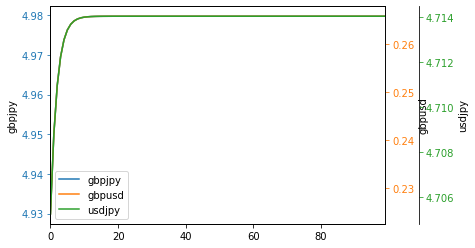

In [78]:
plot_multi(predictions.loc[:, ['gbpjpy', 'gbpusd', 'usdjpy']])